[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/obss/sahi/blob/main/demo/inference_for_yolov5.ipynb)

# Inference on YOLOv8 using Slicing Aided Hyper Inference Technique

## For this inference notebook, packages such as SAHI, Ultralytics, OpenCV and NumPy are required to be installed. 



**NOTE:** After running this cell, the runtime needs to be restarted. After that is done, you can continue with the other cells. 

For restarting the runtime, follow this:



1.   Runtime -> Restart Runtime 
2.   (or) just press *Ctrl + M* 






In [ ]:
# Install necessary packages
!pip install -q torch sahi yolov8 ultralytics numpy opencv-python imantics fiftyone

In [ ]:
# Check current working directory
import os
os.getcwd()

'/content'

## In this inference notebook, we will be using a pretrained YOLOv8-S model, as the Object Detector.

This cell imports the model functions and classes from the SAHI directory.

In [1]:
# Import YOLOv8-S model
from sahi.utils.yolov8 import (
    download_yolov8s_model,
)

# Import required functions and classes
from sahi import AutoDetectionModel
from sahi.utils.cv import read_image
from sahi.utils.file import download_from_url
from sahi.predict import get_prediction, get_sliced_prediction, predict
from sahi.prediction import visualize_object_predictions
from IPython.display import Image
from numpy import asarray
import cv2
import matplotlib.pyplot as plt
import os

This cell downloads the YOLOv8-S model and few test_images to perform inference.

In [2]:
# Download YOLOv8-S model to 'models/yolov8s.pt'
yolov8_model_path = 'models/yolov8s.pt'
download_yolov8s_model(destination_path=yolov8_model_path)

In [3]:
# Download test images into demo_data folder
download_from_url('https://raw.githubusercontent.com/obss/sahi/main/demo/demo_data/small-vehicles1.jpeg', 'demo_data/small-vehicles1.jpeg')
download_from_url('https://raw.githubusercontent.com/obss/sahi/main/demo/demo_data/terrain2.png', 'demo_data/terrain2.png')
download_from_url('https://upload.wikimedia.org/wikipedia/commons/thumb/e/ef/Flock_of_Birds_%287175071318%29.jpg/1200px-Flock_of_Birds_%287175071318%29.jpg', 'demo_data/birds.jpg')
download_from_url('https://images.fineartamerica.com/images/artworkimages/mediumlarge/2/cars-going-home-over-the-golden-gate-bridge-hump-wernher-krutein.jpg', 'demo_data/cars.jpg')
download_from_url('https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTFAkTb-6wnR7PouhkuY0FYlrYVPbllS1mWHb0HI_BFCFDVdSXtDKX07uojqpKhTSPwdQw&usqp=CAU', 'demo_data/cars-evening.jpg')

# Perform Inference on YOLOv8-S model (without and with SAHI)

In this cell, a detection model has been initialized by defining the model weight path, and other necessary parameters such as confidence_threshold and device.

**NOTE:** If you have an Nvidia GPU for CUDA acceleration, then set `device='cuda:0'` otherwise, leave it as `device='cpu'`.

In [4]:
detection_model = AutoDetectionModel.from_pretrained(
    model_type='yolov8',
    model_path=yolov8_model_path,
    confidence_threshold=0.3,
    device="cuda:0", # or 'cpu'
)

## Perform Inference and Visualize (with and without SAHI)

In [5]:
os.makedirs('output_results', exist_ok=True)

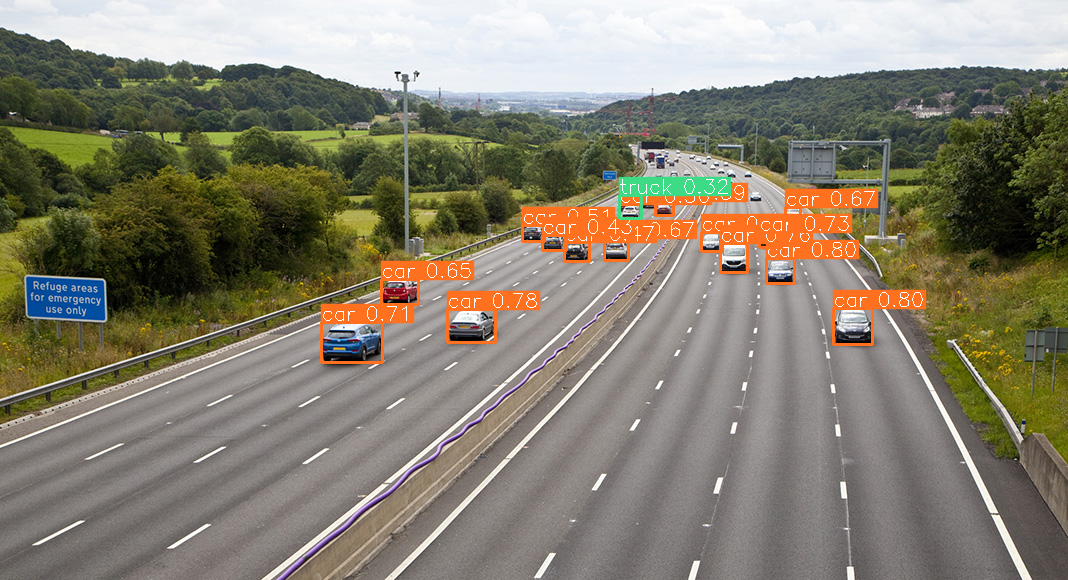

In [6]:
# Example 1
result = get_prediction("demo_data/small-vehicles1.jpeg", detection_model)
result.export_visuals(export_dir="output_results/")

Image("output_results/prediction_visual.png")

**NOTE:** To perform sliced prediction we need to specify slice parameters. In this example we will perform prediction over slices of 256x256 with an overlap ratio of 0.3:

Please feel free to experiement with different `slice_height` and `slice_width`, `overlap_height_ratio`, and `overlap_width_ratio` parameters. More compute is required for more number of slices.

In [7]:
# Example 1
result = get_sliced_prediction(
    "demo_data/small-vehicles1.jpeg",
    detection_model,
    slice_height = 256,
    slice_width = 256,
    overlap_height_ratio = 0.3,
    overlap_width_ratio = 0.3
)

Performing prediction on 18 number of slices.


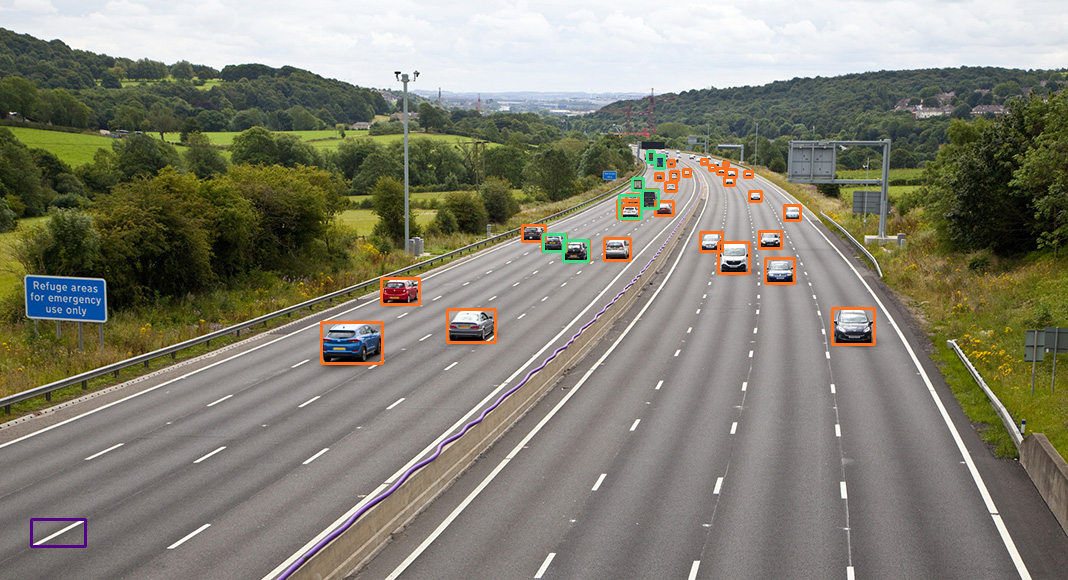

In [8]:
img = cv2.imread("demo_data/small-vehicles1.jpeg", cv2.IMREAD_UNCHANGED)
img_converted = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
numpydata = asarray(img_converted)
visualize_object_predictions(
    numpydata, 
    object_prediction_list = result.object_prediction_list,
    hide_labels = True, 
    output_dir='/content/output_results',
    file_name = 'result',
    export_format = 'png'
)
Image('output_results/result.png')

In [14]:
def compare_with_sahi(
    detection_model,
    image,
    slice_height=None,
    slice_width=None,
    overlap_height_ratio=0.2,
    overlap_width_ratio=0.2,
    hide_labels=False,
    hide_conf=False,
    output_dir="output_results/",
    verbose=0,
):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    # Without SAHI
    result = get_prediction(image, detection_model, verbose=verbose)
    result.export_visuals(export_dir="output_results/", hide_labels=hide_labels, hide_conf=hide_conf)

    # With SAHI
    result = get_sliced_prediction(
        image,
        detection_model,
        slice_height=slice_height,
        slice_width=slice_width,
        overlap_height_ratio=overlap_height_ratio,
        overlap_width_ratio=overlap_width_ratio,
    )
    result.export_visuals(export_dir="output_results/", file_name="prediction_visual_sahi", hide_labels=hide_labels, hide_conf=hide_conf)

    # Plotting
    plt.figure(figsize=(20, 12))
    
    ax1 = plt.subplot(1, 2, 1)
    pred_wo_sahi = plt.imread("output_results/prediction_visual.png")
    ax1.imshow(pred_wo_sahi)
    ax1.title.set_text("Without SAHI")
    plt.axis('off')
    
    ax1 = plt.subplot(1, 2, 2)
    pred_w_sahi = plt.imread("output_results/prediction_visual_sahi.png")
    ax1.imshow(pred_w_sahi)
    ax1.title.set_text("With SAHI")
    plt.axis('off')

    plt.show()

Performing prediction on 15 number of slices.


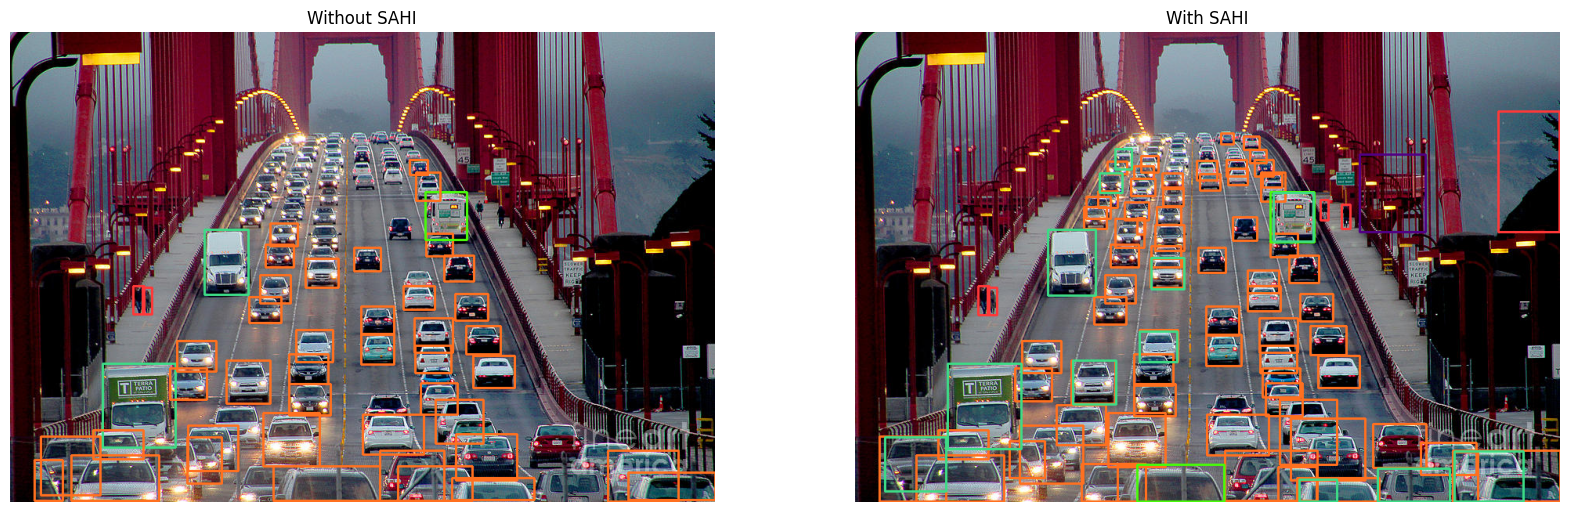

In [15]:
# Example 1
compare_with_sahi(
    detection_model,
    "demo_data/cars.jpg",
    slice_height = 256,
    slice_width = 256,
    overlap_height_ratio = 0.3,
    overlap_width_ratio = 0.3,
    hide_labels=True,
)

Performing prediction on 35 number of slices.


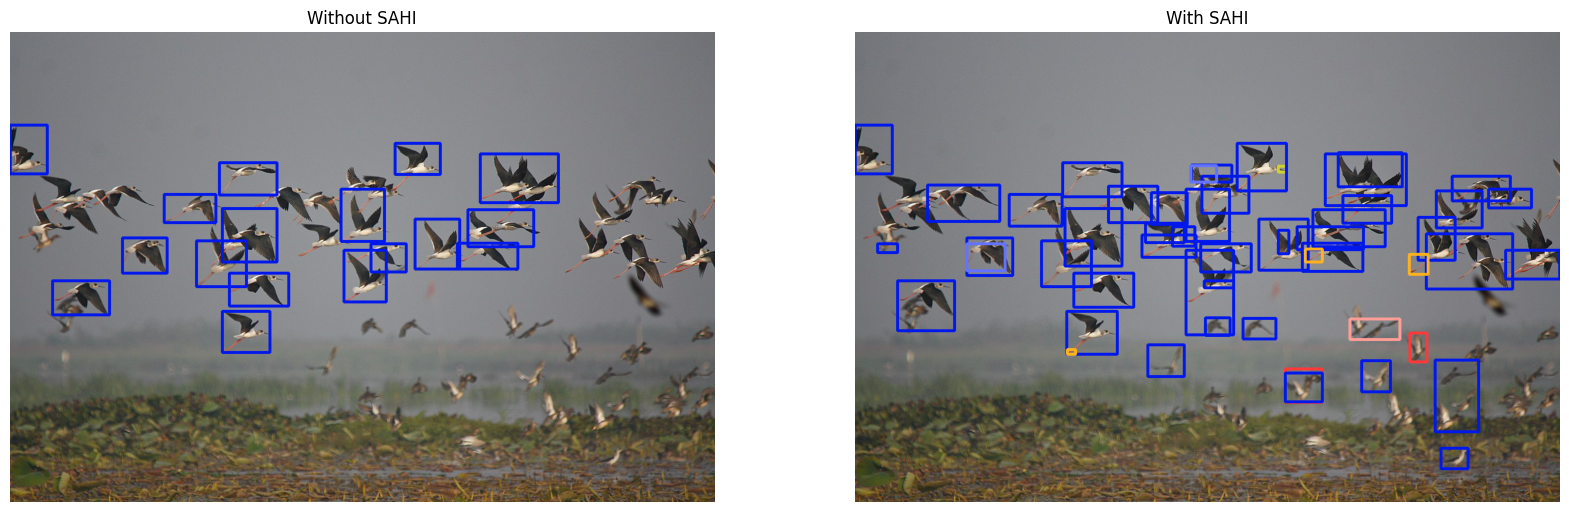

In [16]:
# Example 2 
compare_with_sahi(
    detection_model,
    "demo_data/birds.jpg",
    slice_height = 256,
    slice_width = 256,
    overlap_height_ratio = 0.3,
    overlap_width_ratio = 0.3,
    hide_labels=True,
)

Performing prediction on 2 number of slices.


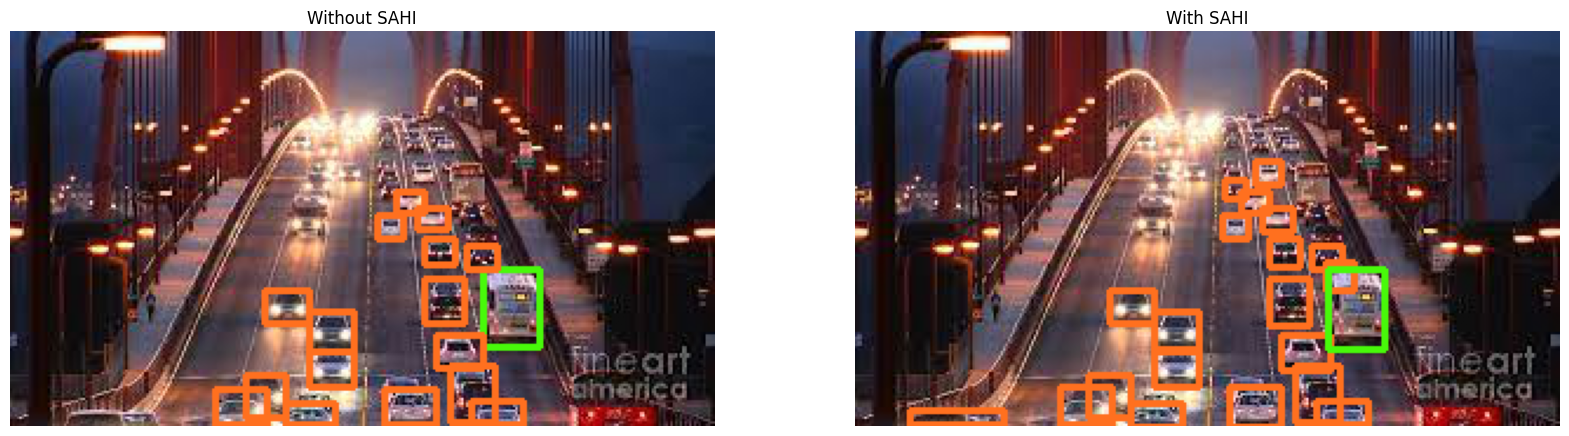

In [17]:
# Example 3 
compare_with_sahi(
    detection_model,
    "demo_data/cars-evening.jpg",
    slice_height = 256,
    slice_width = 256,
    overlap_height_ratio = 0.3,
    overlap_width_ratio = 0.3,
    hide_labels=True,
)

# Prediction Results

- Predictions are returned as [sahi.prediction.PredictionResult](sahi/prediction.py), you can access the object prediction list as:

In [44]:
object_prediction_list = result.object_prediction_list

In [45]:
object_prediction_list[0]

ObjectPrediction<
    bbox: BoundingBox: <(171.7633819580078, 329.9646301269531, 186.94146728515625, 373.67626953125), w: 15.178085327148438, h: 43.711639404296875>,
    mask: None,
    score: PredictionScore: <value: 0.8509994745254517>,
    category: Category: <id: 0, name: person>>

- ObjectPrediction's can be converted to [COCO annotation](https://cocodataset.org/#format-data) format:

In [46]:
result.to_coco_annotations()[:3]

[{'image_id': None,
  'bbox': [171.7633819580078,
   329.9646301269531,
   15.178085327148438,
   43.711639404296875],
  'score': 0.8509994745254517,
  'category_id': 0,
  'category_name': 'person',
  'segmentation': [],
  'iscrowd': 0,
  'area': 663},
 {'image_id': None,
  'bbox': [336.2489776611328,
   112.1358413696289,
   5.6089324951171875,
   17.075294494628906],
  'score': 0.3963398039340973,
  'category_id': 0,
  'category_name': 'person',
  'segmentation': [],
  'iscrowd': 0,
  'area': 95},
 {'image_id': None,
  'bbox': [471.7655029296875,
   442.0960998535156,
   74.46466064453125,
   62.826263427734375],
  'score': 0.8966835141181946,
  'category_id': 2,
  'category_name': 'car',
  'segmentation': [],
  'iscrowd': 0,
  'area': 4678}]

- ObjectPrediction's can be converted to [COCO prediction](https://github.com/i008/COCO-dataset-explorer) format:

In [47]:
result.to_coco_predictions(image_id=1)[:3]

[{'image_id': 1,
  'bbox': [171.7633819580078,
   329.9646301269531,
   15.178085327148438,
   43.711639404296875],
  'score': 0.8509994745254517,
  'category_id': 0,
  'category_name': 'person',
  'segmentation': [],
  'iscrowd': 0,
  'area': 663},
 {'image_id': 1,
  'bbox': [336.2489776611328,
   112.1358413696289,
   5.6089324951171875,
   17.075294494628906],
  'score': 0.3963398039340973,
  'category_id': 0,
  'category_name': 'person',
  'segmentation': [],
  'iscrowd': 0,
  'area': 95},
 {'image_id': 1,
  'bbox': [471.7655029296875,
   442.0960998535156,
   74.46466064453125,
   62.826263427734375],
  'score': 0.8966835141181946,
  'category_id': 2,
  'category_name': 'car',
  'segmentation': [],
  'iscrowd': 0,
  'area': 4678}]

- ObjectPrediction's can be converted to [imantics](https://github.com/jsbroks/imantics) annotation format:

In [50]:
result.to_imantics_annotations()[:3]

- ObjectPrediction's can be converted to [fiftyone](https://github.com/voxel51/fiftyone) detection format:

In [65]:
result.to_fiftyone_detections()[:3]

Migrating database to v0.21.0


INFO:fiftyone.migrations.runner:Migrating database to v0.21.0


[<Detection: {
     'id': '6482919ac5d4159d340c4ee3',
     'attributes': {},
     'tags': [],
     'label': 'person',
     'bounding_box': [
         0.1750678507486979,
         0.5406326802571615,
         0.01535797119140625,
         0.0618737538655599,
     ],
     'mask': None,
     'confidence': 0.7858551144599915,
     'index': None,
 }>,
 <Detection: {
     'id': '6482919ac5d4159d340c4ee4',
     'attributes': {},
     'tags': [],
     'label': 'person',
     'bounding_box': [
         0.6903423563639323,
         0.36804558436075846,
         0.012037243313259548,
         0.05091204961140951,
     ],
     'mask': None,
     'confidence': 0.7800723910331726,
     'index': None,
 }>,
 <Detection: {
     'id': '6482919ac5d4159d340c4ee5',
     'attributes': {},
     'tags': [],
     'label': 'person',
     'bounding_box': [
         0.18855977376302083,
         0.5439801534016927,
         0.0135784912109375,
         0.05804283142089844,
     ],
     'mask': None,
     'confide